**Quantum Scar Dynamics**

Introduction

In this example we show how to use Bloqade to run a quantum scar dynamics experiment. The protocol is as follows: We first prepare the atoms in a Z2 state using an adiabatic sweep. We then apply a Rabi pulse to the atoms, which will cause the atoms to oscillate but because of the Blockade effect, the atoms will not be able to transition to the Rydberg state. However, the atoms will still oscillate between the ground and some other excited many-body states.

**Define the program**

This notebook will also show some advanced features of Bloqade, in particular, how to use the slice and record API to build a program that is compatible with the hardware constraints that the rabi drive must be 0 at the end of the protocol.

The idea is that first we define the full waveform we would like to apply to the atoms then after defining the full waveform you simply call the slice method to slice the that waveform stopping at a variable time run_time. This works fine for detuning but for the Rabi drive, we need to make sure that the Rabi drive is 0 at the end of the the waveform. To do this, we use the record method to record the value of the Rabi drive at the end of the waveform. We then use the linear method to append a segment to the waveform that fixes the value of the Rabi drive to 0 at the end of the waveform. Now any value of run_time will be a valid waveform that is compatcible with the hardware constraints.

In [90]:
from bloqade import var, save, load
from bloqade.atom_arrangement import Chain, Square
import matplotlib.pyplot as plt
import numpy as np
import os

In [91]:
if not os.path.isdir("data"):
    os.mkdir("data")

n_atoms = 9
lattice_spacing = 6.1
run_time = var("run_time")
omega_mult = 1

In [192]:
delta_end = 42.66
omega_max = 90.0
sweep_time = 1.6 #time length of program 
lattice_spacing = 7.0 #size of edges of square lattice
L=3 # number of unit cells in each direction

C6 = 2*np.pi * 862690;
Rb = (C6 / (omega_max) )** (1/6) # R_B during bulk of protocol
print("Rb/a: ",Rb/lattice_spacing)


print("Delta/Omega: ", delta_end/omega_max)

Rb/a:  0.8525323304997569
Delta/Omega:  0.3555


In [193]:
rabi_amplitude_values = [0.0, omega_max, omega_max, 0.0]
rabi_detuning_values = [-delta_end, -delta_end, delta_end, delta_end]
durations = [0.3, sweep_time, 0.3]

In [194]:
quantum_scar_program = (
    Square(L, lattice_spacing=lattice_spacing)

    # define detuning waveform
    .rydberg.detuning.uniform.piecewise_linear(durations, rabi_detuning_values)
    .piecewise_linear([0.2, 1.6], [16.3, 0.0, 0.0])
    .slice(start=0, stop=run_time)

    # define rabi waveform
    .rydberg.rabi.amplitude.uniform.piecewise_linear(durations, rabi_amplitude_values)
    .piecewise_linear([0.2, 1.4, 0.2], [0, 15.7, 15.7, 0])
    .slice(start=0, stop=run_time - 0.065)

    .record("rabi_value")
    .linear("rabi_value", 0, 0.065)
)

In [195]:
"""floor = np.floor(np.sqrt(n_atoms))
ceil = np.ceil(n_atoms/floor)
quantum_scar_program = (
    Square(int(floor), int(ceil), lattice_spacing=lattice_spacing)
    #

    # define detuning waveform
    .rydberg.detuning.uniform.piecewise_linear(
        [0.8, 2.4, 0.8], [-42.66, -42.66, 42.66, 42.66]
    )

    .piecewise_linear([0.2, 1.6], [16.3, 0.0, 0.0])

    # slice the detuning waveform
    .slice(start=0, stop=run_time)

    # define rabi waveform
    .amplitude.uniform.piecewise_linear([0.3, 1.6, 0.3], [0.0 * omega_mult, 15.7 * omega_mult, 15.7 * omega_mult, 0.0 * omega_mult])
    .piecewise_linear([0.2, 1.4, 0.2], [0, 15.7, 15.7, 0])

    # slice waveform, add padding for the linear segment
    .slice(start=0, stop=run_time - 0.065)

    # record the value of the waveform at the end of the slice to "rabi_value"
    .record("rabi_value")

    # append segment to waveform that fixes the value of the waveform to 0 at the end of the waveform
    .linear("rabi_value", 0, 0.065)"""

'floor = np.floor(np.sqrt(n_atoms))\nceil = np.ceil(n_atoms/floor)\nquantum_scar_program = (\n    Square(int(floor), int(ceil), lattice_spacing=lattice_spacing)\n    #\n\n    # define detuning waveform\n    .rydberg.detuning.uniform.piecewise_linear(\n        [0.8, 2.4, 0.8], [-42.66, -42.66, 42.66, 42.66]\n    )\n\n    .piecewise_linear([0.2, 1.6], [16.3, 0.0, 0.0])\n\n    # slice the detuning waveform\n    .slice(start=0, stop=run_time)\n\n    # define rabi waveform\n    .amplitude.uniform.piecewise_linear([0.3, 1.6, 0.3], [0.0 * omega_mult, 15.7 * omega_mult, 15.7 * omega_mult, 0.0 * omega_mult])\n    .piecewise_linear([0.2, 1.4, 0.2], [0, 15.7, 15.7, 0])\n\n    # slice waveform, add padding for the linear segment\n    .slice(start=0, stop=run_time - 0.065)\n\n    # record the value of the waveform at the end of the slice to "rabi_value"\n    .record("rabi_value")\n\n    # append segment to waveform that fixes the value of the waveform to 0 at the end of the waveform\n    .linear("r

In [196]:
Square(L, lattice_spacing=lattice_spacing)

                                   Atom Positions                               
    ┌──────────────────────────────────────────────────────────────────────────┐
14.0┤•                                    •                                   •│
    │                                                                          │
    │                                                                          │
11.7┤                                                                          │
    │                                                                          │
    │                                                                          │
 9.3┤                                                                          │
    │                                                                          │
    │                                                                          │
 7.0┤•                                    •                                   •│
    │                       

In [197]:
# get run times via the following:
prep_times = np.arange(0.2, 2.2, 0.2)
scar_times = np.arange(2.2, 4.01, 0.01)
run_times = np.unique(np.hstack((prep_times, scar_times)))

batch = quantum_scar_program.batch_assign(run_time=run_times - 0.1)

In [198]:
run_times

array([0.2 , 0.4 , 0.6 , 0.8 , 1.  , 1.2 , 1.4 , 1.6 , 1.8 , 2.  , 2.2 ,
       2.21, 2.22, 2.23, 2.24, 2.25, 2.26, 2.27, 2.28, 2.29, 2.3 , 2.31,
       2.32, 2.33, 2.34, 2.35, 2.36, 2.37, 2.38, 2.39, 2.4 , 2.41, 2.42,
       2.43, 2.44, 2.45, 2.46, 2.47, 2.48, 2.49, 2.5 , 2.51, 2.52, 2.53,
       2.54, 2.55, 2.56, 2.57, 2.58, 2.59, 2.6 , 2.61, 2.62, 2.63, 2.64,
       2.65, 2.66, 2.67, 2.68, 2.69, 2.7 , 2.71, 2.72, 2.73, 2.74, 2.75,
       2.76, 2.77, 2.78, 2.79, 2.8 , 2.81, 2.82, 2.83, 2.84, 2.85, 2.86,
       2.87, 2.88, 2.89, 2.9 , 2.91, 2.92, 2.93, 2.94, 2.95, 2.96, 2.97,
       2.98, 2.99, 3.  , 3.01, 3.02, 3.03, 3.04, 3.05, 3.06, 3.07, 3.08,
       3.09, 3.1 , 3.11, 3.12, 3.13, 3.14, 3.15, 3.16, 3.17, 3.18, 3.19,
       3.2 , 3.21, 3.22, 3.23, 3.24, 3.25, 3.26, 3.27, 3.28, 3.29, 3.3 ,
       3.31, 3.32, 3.33, 3.34, 3.35, 3.36, 3.37, 3.38, 3.39, 3.4 , 3.41,
       3.42, 3.43, 3.44, 3.45, 3.46, 3.47, 3.48, 3.49, 3.5 , 3.51, 3.52,
       3.53, 3.54, 3.55, 3.56, 3.57, 3.58, 3.59, 3.

**Run on Emulator and Hardware**

We will run the experiment on the emulator and hardware, saving the results to disk so that we can plot them later. for more details on where these lines of code come from, see the first few tutorials.

In [199]:

emu_filename = os.path.join(
    os.path.abspath(""), "data", "quantum-scar-dynamics-emulation.json"
)


emu_batch = batch.bloqade.python().run(1000, interaction_picture=True)
save(emu_batch, emu_filename)


filename = os.path.join(os.path.abspath(""), "data", "quantum-scar-dynamics-job.json")

In [152]:
"""if not os.path.isfile(filename):
    hardware_batch = (
        batch.parallelize(24)
        .braket.aquila()
        .run_async(100, ignore_submission_error=True)
    )
    save(hardware_batch, filename)"""

'if not os.path.isfile(filename):\n    hardware_batch = (\n        batch.parallelize(24)\n        .braket.aquila()\n        .run_async(100, ignore_submission_error=True)\n    )\n    save(hardware_batch, filename)'

**Plotting the results**

The quantity we are interested in is the probability of the atoms being in the Z2 state. 
We can get this by looking at the counts of the Z2 state in the report. 
Below we define a function that will get the probability of the Z2 state for each time step in the experiment.

In [200]:
emu_batch = load(emu_filename)
hardware_batch = load(filename)
# hardware_batch.fetch()
# save(hardware_batch, filename)

#create variable that auto updates bitstring 
prep_state_list = [0 if i % (1 + 1) < 1 else 1 for i in range(n_atoms)]

prep_state_string = ''
for i in prep_state_list: 
    prep_state_string += str(i)

print(prep_state_string)
    

def get_z2_probabilities(report):
    z2_probabilities = []

    for count in report.counts():
        z2_probability = count.get(prep_state_string, 0) / sum(list(count.values()))
        z2_probabilities.append(z2_probability)

    return z2_probabilities

010101010


We can now plot the results from the emulator and hardware. We see that the emulator

In [201]:
emu_z2_prob

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.031,
 0.366,
 0.697,
 0.818,
 0.964,
 0.978,
 0.979,
 0.981,
 0.981,
 0.985,
 0.992,
 0.991,
 0.997,
 0.997,
 0.999,
 0.996,
 0.998,
 0.996,
 0.998,
 0.996,
 0.996,
 0.996,
 0.988,
 0.986,
 0.97,
 0.951,
 0.926,
 0.872,
 0.84,
 0.726,
 0.64,
 0.576,
 0.456,
 0.362,
 0.287,
 0.198,
 0.102,
 0.078,
 0.038,
 0.02,
 0.016,
 0.008,
 0.002,
 0.002,
 0.0,
 0.0,
 0.001,
 0.001,
 0.0,
 0.0,
 0.001,
 0.002,
 0.002,
 0.011,
 0.021,
 0.025,
 0.043,
 0.06,
 0.098,
 0.147,
 0.19,
 0.233,
 0.318,
 0.305,
 0.339,
 0.406,
 0.368,
 0.373,
 0.32,
 0.277,
 0.197,
 0.175,
 0.118,
 0.115,
 0.102,
 0.095,
 0.08,
 0.077,
 0.04,
 0.017,
 0.014,
 0.006,
 0.015,
 0.014,
 0.038,
 0.054,
 0.082,
 0.081,
 0.076,
 0.064,
 0.049,
 0.033,
 0.024,
 0.021,
 0.03,
 0.033,
 0.048,
 0.087,
 0.113,
 0.137,
 0.153,
 0.179,
 0.195,
 0.172,
 0.14,
 0.138,
 0.139,
 0.108,
 0.131,
 0.14,
 0.162,
 0.182,
 0.193,
 0.236,
 0.218,
 0.206,
 0.197,
 0.125,
 0.091,
 0.072,
 0.049,
 0.023,
 0.02,
 

<>:18: SyntaxWarning: invalid escape sequence '\m'
<>:18: SyntaxWarning: invalid escape sequence '\m'
C:\Users\ywang_sy2849a\AppData\Local\Temp\ipykernel_54484\1389195581.py:18: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel("Time ($\mu s$)")


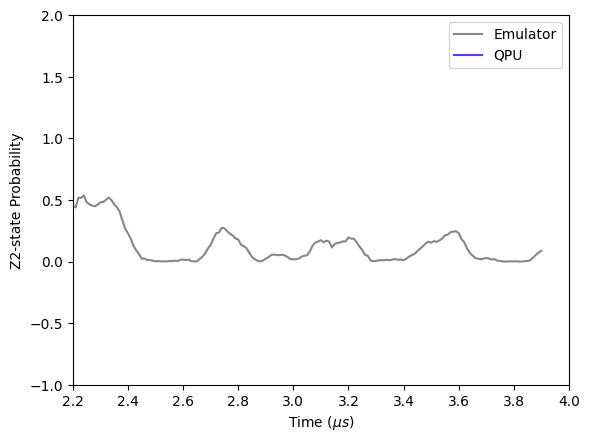

<Figure size 640x480 with 0 Axes>

In [202]:
emu_report = emu_batch.report()
# hardware_report = hardware_batch.report()

emu_run_times = emu_report.list_param("run_time")
emu_z2_prob = get_z2_probabilities(emu_report)

hw_run_times = hardware_report.list_param("run_time")
hw_z2_prob = get_z2_probabilities(hardware_report)


plt.plot(emu_run_times, emu_z2_prob, label="Emulator", color="#878787")
plt.plot(hw_run_times, hw_z2_prob, label="QPU", color="#6437FF")

plt.xlim(2.2, 4.0)
plt.ylim(-1, 2)

plt.legend()
plt.xlabel("Time ($\mu s$)")
plt.ylabel("Z2-state Probability")
plt.show()
plt.savefig("SQUARE test 4")

In [144]:
emu_report.rydberg_densities()

,0,1,2,3,4,5,6,7,8
task_number,,,,,,,,,
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.02,0.01,0.02,0.00,0.00,0.01,0.01,0.02,0.02
2,0.02,0.00,0.03,0.02,0.04,0.00,0.03,0.06,0.03
3,0.09,0.06,0.07,0.06,0.06,0.04,0.07,0.03,0.06
4,0.10,0.06,0.12,0.08,0.10,0.11,0.07,0.05,0.08
5,0.25,0.13,0.27,0.12,0.09,0.11,0.15,0.16,0.27
6,0.44,0.17,0.42,0.18,0.11,0.13,0.42,0.18,0.44
7,0.82,0.02,0.84,0.01,0.36,0.04,0.88,0.03,0.84
8,0.82,0.04,0.87,0.06,0.63,0.03,0.80,0.04,0.85
